Lib imports, ds paths etc.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from scripts.scripts import *

In [2]:
data_paths = {}

for dirname, _, filenames in os.walk('../competitive-data-science-predict-future-sales'):
    for filename in filenames:
        data_paths[filename] = f"{dirname}/{filename}"

In [3]:
data = {}

for file, path in data_paths.items():
    data[file.split('.')[0]] = pd.read_csv(path)

# DQC

### Dataframe overview

There are six tables in total:

1. item_categories: The table consists of two columns, item_id and category_id corresponding to the item.
2. items: three columns, item_id, category_id and item_name.
3. sales_rain: The table consists of six columns. date, date_block_num (hereinafter defined as month), shop_id, item_id, item_price, item_cnt_day (number of item sales on the corresponding day).
4. shops: A table of store IDs and shop names.
5. sample_submission: An example of the format in which predictions should be made.
6. test: The data on which predictions should be made.



## Overview all tables

In [4]:
print("Items Description:")
print(data['items'].describe())

print("\nShops Description:")
print(data['shops'].describe())

print("\nItem Categories Description:")
print(data['item_categories'].describe())

Items Description:
           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000         58.000000
max    22169.00000         83.000000

Shops Description:
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000

Item Categories Description:
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000


Overall there's nothing strange or suspicious in that dataframes, because that dataframes is not as complex as sales_train.

### First of all
 let's check df for unique items, amount of Nan values and total amount of items in every table and column. It can help to understand data consistensy and see if there any outliers.

In [5]:
unique_nan_total(data)

,table_name,column_name,unique_count,nan_count,total_count,dtype
0,items,item_name,22170,0,22170,object
1,items,item_id,22170,0,22170,int64
2,items,item_category_id,84,0,22170,int64
3,item_categories,item_category_name,84,0,84,object
4,item_categories,item_category_id,84,0,84,int64
5,sales_train,date,1034,0,2935849,object
6,sales_train,date_block_num,34,0,2935849,int64
7,sales_train,shop_id,60,0,2935849,int64
8,sales_train,item_id,21807,0,2935849,int64
9,sales_train,item_price,19993,0,2935849,float64


There are several issues with the data. For example, 
- we have 60 different shops in total, but only 42 different shops in the test set
- the item_id counts are: test: 5100, items: 22170, train: 21807

What's wrong with item_id and shop_id:
- item_id:

The number of unique item_id's in the sales_train table (21,807) is slightly less than the number in the items table (22,170). This may mean that some items were not sold or were not recorded in the sales_train table in this time period.
It may also mean that not all items are available for sale in all stores (some items may only be available in certain stores).

- shop_id:

The number of unique shop_id's in the sales_train table (60) matches the number of unique stores in the shops table, which confirms that the stores are correct.
However, you will only need to use the 42 stores listed in the test table to make a prediction. This means that you don't need to consider sales for all 60 stores, just those 42.

In conclusion, not all data in the dataset is useful for training.

Given the number of dates in the file and the somewhat non-intuitive parameter "date_block_num," we can assume that "date_block_num" refers to months. This means we have data for 34 months between 2013 and 2015, implying that our timeline does not start on the first day of 2013 or end on 31.12.2015. In the worst-case scenario, there are gaps in our data.



Filter the prediction set by shops and items that is not in test set, that data wouldn't be useful for training.

In [6]:
df_research = data['sales_train'].copy()
df_prediction = data['sales_train'].copy()

In [7]:
test_items = data['test']['item_id'].unique()
test_shops = data['test']['shop_id'].unique()

df_prediction = df_prediction[
    df_prediction['item_id'].isin(test_items) & df_prediction['shop_id'].isin(test_shops)
]

print(f"df_prediction shape after filtering: {df_prediction.shape}")


df_prediction shape after filtering: (1224439, 6)


### Performing timeline check to see if there any gaps in data.

In [8]:
timeline_check(data)

First date in timeline: 2013-01-01 00:00:00, last date in timeline: 2015-10-31 00:00:00

No dates skipped.



There's no skipped dates, that means there wasn't any day all the franchise stopped it's work.

### To detect outliers checking dataset for min/max/mean values in every table and index. If there is something suspicious we'll perform more specific check.

In [9]:
percs = df_research[['item_cnt_day','item_price']].describe(percentiles=[0.01, 0.05,0.2,0.5, 0.7, 0.9, 0.95, 0.99])
print(f"df_research shape after filtering outliers: {df_research.shape}")

percs

df_research shape after filtering outliers: (2935849, 6)


,item_cnt_day,item_price
count,2.935849e+06,2.935849e+06
mean,1.242641e+00,8.908532e+02
std,2.618834e+00,1.729800e+03
min,-2.200000e+01,-1.000000e+00
1%,1.000000e+00,5.000000e+00
5%,1.000000e+00,9.900000e+01
20%,1.000000e+00,1.990000e+02
50%,1.000000e+00,3.990000e+02
70%,1.000000e+00,7.990000e+02
90%,2.000000e+00,1.999000e+03


Sales are generally small: 90% of values ​​are up to 2 items per day, but there are abnormal data: negative values ​​and outliers (up to 2,169 items).

Most items have a price of up to 2,000–2,600 rubles, but there are anomalies:

- negative price values;
- extremely high prices (up to 307,980 rubles), which look like outliers.

General data issues:
1. Negative values ​​in item_cnt_day and item_price:
May indicate data entry errors or product returns.
2. Outliers:
In item_cnt_day, sales of up to 2,169 items look like an anomaly.
In item_price, prices up to 307,980 rubles are also suspiciously high.

## Plotting the data distribution (item count and item price distributions)

C:\Users\vladi\AppData\Local\Temp\ipykernel_13756\477601048.py:6: RuntimeWarning: divide by zero encountered in log10
  log_cnt = np.log10(aggregated_cnt.values)
C:\Users\vladi\AppData\Local\Temp\ipykernel_13756\477601048.py:6: RuntimeWarning: invalid value encountered in log10
  log_cnt = np.log10(aggregated_cnt.values)


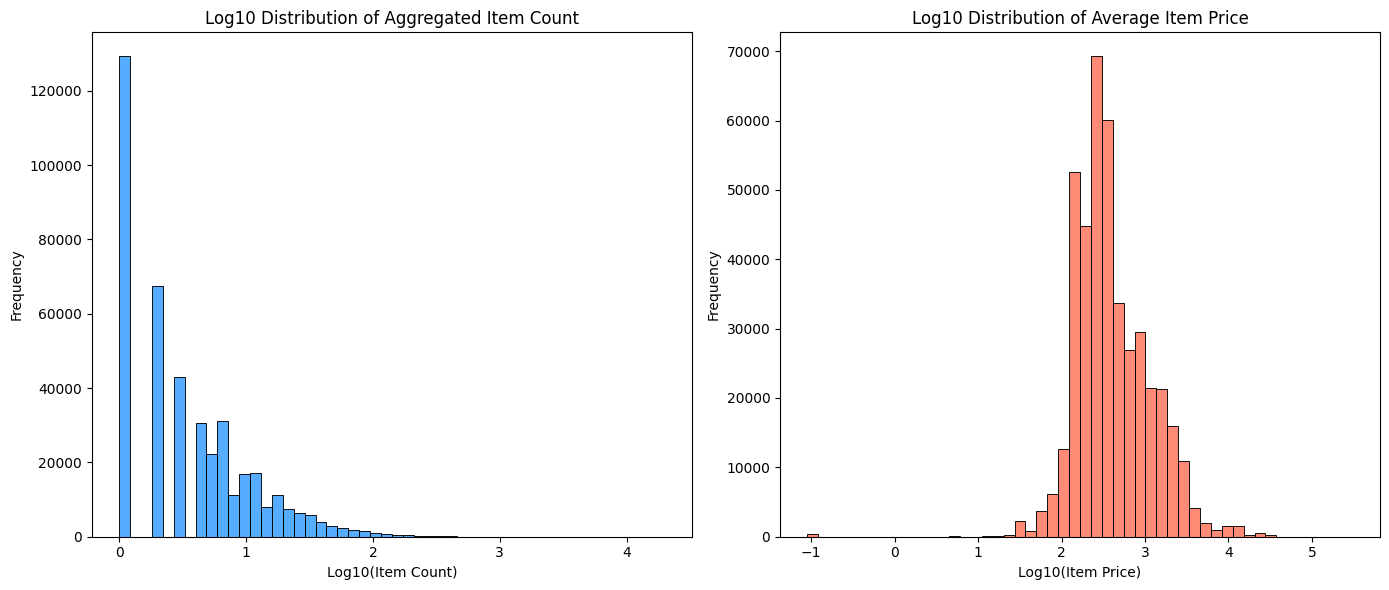

In [10]:
aggregated_cnt = df_research.groupby(['item_id', 'shop_id'])['item_cnt_day'].sum()
aggregated_price = df_research.groupby(['item_id', 'shop_id'])['item_price'].mean()
aggregated_cnt.reset_index()
aggregated_price.reset_index()

log_cnt = np.log10(aggregated_cnt.values)
log_price = np.log10(aggregated_price.values)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(log_cnt, bins=50, color='dodgerblue', ax=axes[0])
axes[0].set_title('Log10 Distribution of Aggregated Item Count')
axes[0].set_xlabel('Log10(Item Count)')
axes[0].set_ylabel('Frequency')

sns.histplot(log_price, bins=50, color='tomato', ax=axes[1])
axes[1].set_title('Log10 Distribution of Average Item Price')
axes[1].set_xlabel('Log10(Item Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
print(f"df_research shape after filtering outliers: {df_research.shape}")
percs = df_research[['item_cnt_day', 'item_price']].describe(percentiles=[0.01, 0.99])

lower_bound_item_cnt = percs.loc['1%', 'item_cnt_day']
upper_bound_item_cnt = percs.loc['99%', 'item_cnt_day']
lower_bound_item_price = percs.loc['1%', 'item_price']
upper_bound_item_price = percs.loc['99%', 'item_price']

df_research = df_research[
    (df_research['item_cnt_day'] >= lower_bound_item_cnt) &
    (df_research['item_cnt_day'] <= upper_bound_item_cnt) &
    (df_research['item_price'] >= lower_bound_item_price) &
    (df_research['item_price'] <= upper_bound_item_price)
]

print(f"df_research shape after filtering outliers: {df_research.shape}")


df_research shape after filtering outliers: (2935849, 6)
df_research shape after filtering outliers: (2866929, 6)


Let's plot the distributions again

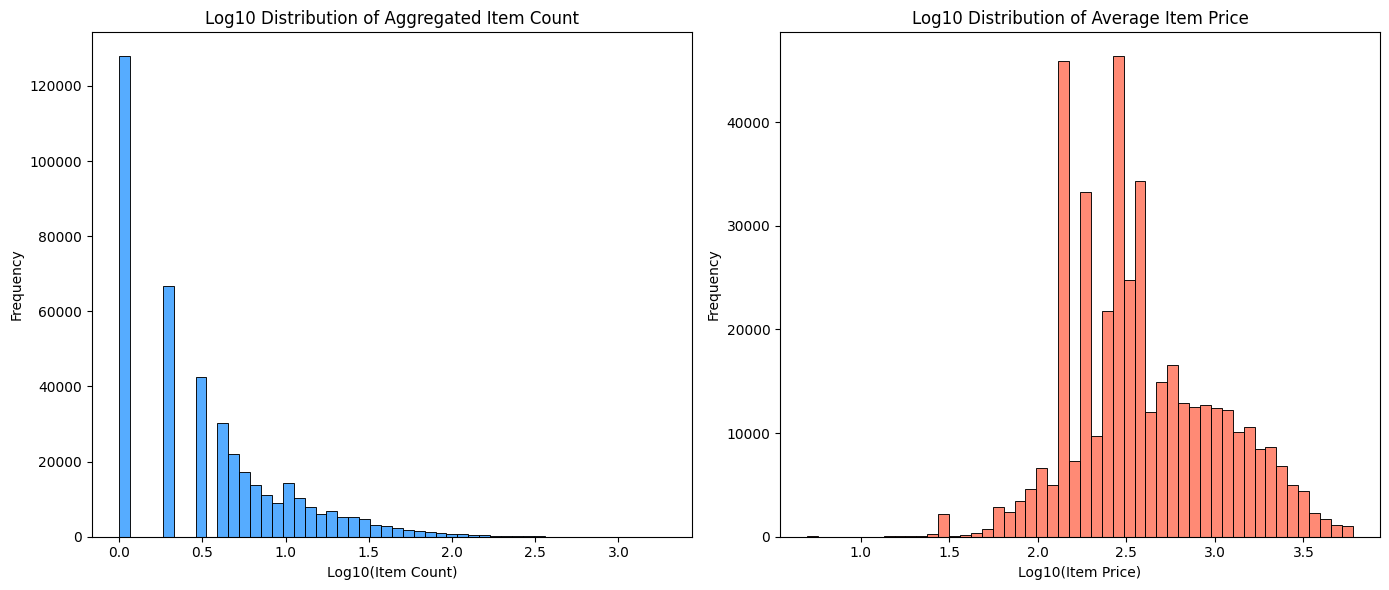

In [12]:
aggregated_cnt = df_research.groupby(['item_id', 'shop_id'])['item_cnt_day'].sum()
aggregated_price = df_research.groupby(['item_id', 'shop_id'])['item_price'].mean()
aggregated_cnt.reset_index()
aggregated_price.reset_index()

log_cnt = np.log10(aggregated_cnt.values)
log_price = np.log10(aggregated_price.values)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(log_cnt, bins=50, color='dodgerblue', ax=axes[0])
axes[0].set_title('Log10 Distribution of Aggregated Item Count')
axes[0].set_xlabel('Log10(Item Count)')
axes[0].set_ylabel('Frequency')

sns.histplot(log_price, bins=50, color='tomato', ax=axes[1])
axes[1].set_title('Log10 Distribution of Average Item Price')
axes[1].set_xlabel('Log10(Item Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Now distributions are more uniform-like

### Negative values in data check (item_cnt_month = -1, item_cnt_day = -22.)

Firstly check the item price column with value '-1'

In [13]:
get_negative_rows_by_column(data['sales_train']['item_price'])

484683   -1.0
Name: item_price, dtype: float64

Theres only one case of presisting of such type negative value, so it can be considered an outlier an deleted.

Checking all the sales thain for negative values.

In [14]:
get_negative_rows(data['sales_train'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


This occurs systematically, indicating it is not a mistake but possibly just returns. We can try to find the explanation.

Checking the skips in shops, that way we can find the shop IDs that never ha a negative value in item_cnt_day.

In [15]:
check_for_skips(get_negative_rows(data['sales_train'])['shop_id'])

[0, 1, 10, 11, 13, 51]

Only six shop ID never dealt with a negative values, seems like it's really returns.

Checking for what item_name s are mostly compared with negative values to understand is it really returns. Let's print top-10 of them.

In [16]:
counted_returns = count_elements(get_negative_rows(data['sales_train'])['item_id'])
top_returns = dict(sorted(counted_returns.items(), key=lambda x: x[1], reverse=True)[:10])
print(get_item_names(data['items'], top_returns))

['Bestseller. S.T.A.L.K.E.R. [PC, Jewel]', 'Call of Duty: Ghosts [PS4, русская версия]', 'Grand Theft Auto V [PS3, русские субтитры]', 'Grand Theft Auto V [Xbox 360, русские субтитры]', 'Kinect Rush [только для Kinect] [Xbox 360]', 'Kinect Star Wars [только для Kinect] [Xbox 360]', 'LEGO Batman 2: DC Super Heroes [PС, Jewel, русские субтитры]', 'PS3: Гарнитура беспроводная для PS3 (с поддержкой PS4) (Pulse Wireless Stereo Headset: CECHYA-0086:', 'PS4: Контроллер игровой беспроводной черный (Dualshock 4 Cont Anthracite Black: CUH-ZCT1: SCEE)', 'Одни из нас [PS3, русская версия]']


Plot the distribution of possible returns

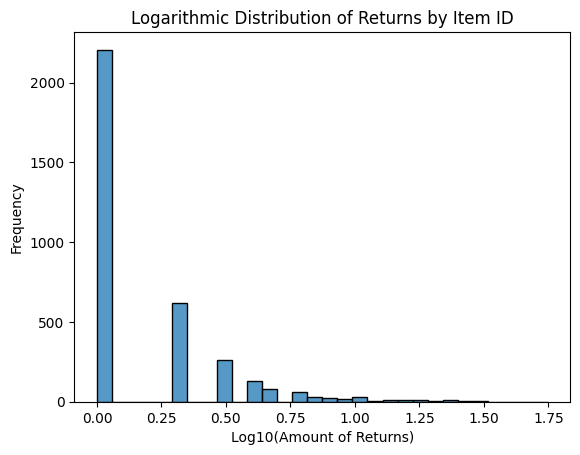

In [17]:
import numpy as np

log_counts = np.log10(list(counted_returns.values()))

sns.histplot(log_counts, kde=False, bins=30)
plt.title('Logarithmic Distribution of Returns by Item ID')
plt.xlabel('Log10(Amount of Returns)')
plt.ylabel('Frequency')
plt.show()



We see that most things in the data have few or no returns, while some have a lot of returns.
Also, most returns involve video games, which is very plausible. Therefore, we can say that this is certainly not a mistake, and we have to admit it.

## Checking dataframes for duplicates

Check 'shops' for duplicates:

In [18]:
find_potential_duplicates(data["shops"], "shop_name")

[('РостовНаДону ТРК "Мегацентр Горизонт"',
  'РостовНаДону ТРК "Мегацентр Горизонт" Островной',
  88.09523809523809),
 ('!Якутск ТЦ "Центральный" фран',
  'Якутск ТЦ "Центральный"',
  88.46153846153845),
 ('Жуковский ул. Чкалова 39м?',
  'Жуковский ул. Чкалова 39м²',
  96.15384615384616),
 ('Москва ТК "Буденовский" (пав.А2)',
  'Москва ТК "Буденовский" (пав.К7)',
  93.75),
 ('!Якутск Орджоникидзе, 56 фран',
  'Якутск Орджоникидзе, 56',
  88.46153846153845)]

These duplicates look more like a dataframe compiler error than really different stores with a very similar name. Only those duplicates that have a longer lifetime can be kept.

Checking 'items' df for duplicates

In [19]:
# find_potential_duplicates(data["items"], "item_name")

*NOTE: Output is too long, due that cell output is clear.*

The duplicates found visually look like really different positions, although they have high similarity scores. The number of duplicates is too large to draw any specific conclusions. No changes will be made.

In [20]:
find_potential_duplicates(data["item_categories"], "item_category_name", similarity_threshold=90)

[('Игры - PS2', 'Игры - PS4', 90.0),
 ('Игровые консоли - PS2', 'Игровые консоли - PS4', 95.23809523809523),
 ('Аксессуары - PS4', 'Аксессуары - PSP', 93.75),
 ('Игровые консоли - PS2', 'Игровые консоли - PS3', 95.23809523809523),
 ('Игры - PS3', 'Игры - PSP', 90.0),
 ('Игровые консоли - PS3', 'Игровые консоли - PSP', 95.23809523809523),
 ('Игры - PS3', 'Игры - PS4', 90.0),
 ('Аксессуары - PS2', 'Аксессуары - PSP', 93.75),
 ('Игровые консоли - PS4', 'Игровые консоли - PSP', 95.23809523809523),
 ('Игровые консоли - PS2', 'Игровые консоли - PSP', 95.23809523809523),
 ('Игры - PS2', 'Игры - PS3', 90.0),
 ('Игры MAC - Цифра', 'Игры PC - Цифра', 90.32258064516128),
 ('Кино - Blu-Ray', 'Кино - Blu-Ray 4K', 90.32258064516128),
 ('Кино - Blu-Ray', 'Кино - Blu-Ray 3D', 90.32258064516128),
 ('Аксессуары - PS2', 'Аксессуары - PS4', 93.75),
 ('Аксессуары - PS2', 'Аксессуары - PS3', 93.75),
 ('Аксессуары - PS3', 'Аксессуары - PSP', 93.75),
 ('Аксессуары - PS3', 'Аксессуары - PS4', 93.75),
 ('Игры -

The duplicates found, although they have almost identical names, are still different positions. Most of all duplicates found contain substrings like "PS", which is not a reason for deletion. I don't think it's necessary to make changes to this dataframe

### Timeline check for every shop separately

There are 50+ shops in dataset, it can be assumed that not every shop existed over the three years that our data covers. Would be useful to check every shop timeline to unerstand their lifetime.

In [21]:
sales_df = pd.DataFrame(data['sales_train'])
shops_df = pd.DataFrame(data['shops'])

sorted_working_days_dict = get_shop_working_days_sorted(sales_df, shops_df)
top10 = dict(islice(sorted_working_days_dict.items(), 10))

for shop_name, working_days in top10.items():
    print(f"Shop: {shop_name}, Dаys shop worked: {working_days}")


Shop: Москва "Распродажа", Dаys shop worked: 9
Shop: Выездная Торговля, Dаys shop worked: 14
Shop: Новосибирск ТРЦ "Галерея Новосибирск", Dаys shop worked: 14
Shop: Жуковский ул. Чкалова 39м², Dаys shop worked: 28
Shop: !Якутск ТЦ "Центральный" фран, Dаys shop worked: 56
Shop: !Якутск Орджоникидзе, 56 фран, Dаys shop worked: 57
Shop: Воронеж ТРЦ Сити-Парк "Град", Dаys shop worked: 84
Shop: Москва ТК "Буденовский" (пав.А2), Dаys shop worked: 117
Shop: Москва ТЦ "Серебряный Дом", Dаys shop worked: 183
Shop: Мытищи ТРК "XL-3", Dаys shop worked: 201


Some shops have a very short lifespan. I think it would be useful to remove shops that have existed for less than a half month.

# ETL
After DQC performed we can do the ETL relying on DQC.
- Remove or correct negative values ​​in item_cnt_day and item_price where necessary.
- Filter outliers at 1st and 99th percentile for item_cnt_day and item_price.
- Merge duplicate stores and correct data.
- Remove invalid products and stores if they have incorrect or missing data.
- Merge tables (sales_train, items, shops, item_categories) to create consistent data.
- Validate dates and create new time features.

In [25]:
from scripts.etl import etl

cleaned_data = etl(data)
etl_data = pd.read_csv('sales_train_complete.csv')
etl_data.info()

Negative values in item_cnt_day: 7356
Negative values in item_price: 0
sales_train shape after filtering outliers: (2843929, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066138 entries, 0 to 1066137
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1066138 non-null  object 
 1   date__month          1066138 non-null  int64  
 2   shop_id              1066138 non-null  int64  
 3   item_id              1066138 non-null  int64  
 4   item_price           1066138 non-null  float64
 5   item_cnt_day         1066138 non-null  float64
 6   item_category_id     1066138 non-null  int64  
 7   item_name            1066138 non-null  object 
 8   item_category_name   1066138 non-null  object 
 9   shop_name            1066138 non-null  object 
 10  date__day            1066138 non-null  int64  
 11  date__week           1066138 non-null  int64  
 12  date__day_of_month   10661

# Conclusion
The dataset was analyzed and cleaned to ensure better data quality and usability. Below is a summary of the issues identified and actions taken:

1. Negative values for item_price and item_cnt_day were present.
3. Extremely high item_cnt_day values (> 200) were deemed unrealistic and likely erroneous.
4. Several shops were identified as potential duplicates based on their names (e.g., differences in formatting or encoding).
5. Shops with less than 15 days of recorded activity were identified as unreliable for analysis.


Most tables are well-structured with no significant missing data.
Short-lived shops and duplicate shops slightly reduced the dataset size but improved reliability.
Outliers and unrealistic values have been removed, ensuring a more accurate representation of sales.

### Overall

The data quality has improved after cleaning. However, some limitations remain due to potential unrecorded sales, shop closures, or system errors.
This cleaned data is now better suited for forecasting tasks, such as predicting monthly sales.